In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install numpy pandas matplotlib transformers accelerate mlx-lm -qqq
#!pip install flash_attn

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import os.path as osp 

import pandas as pd
from pprint import pprint

import re

import sys
sys.path.append("../")

from tqdm.auto import tqdm
import torch
import torch.nn as nn

from typing import Tuple, Any

In [3]:
from src.__init__ import logger
from src.config import Config
from src.model import ARCModel
from src.utils import (load_data, 
                        sample_arc_task, 
                        visualize_task, 
                        infer_out_shape,
                        get_row_sizes,
                        get_grid_shape)

In [4]:
base_prompt_path = "../src/base_prompt.txt"

with open(base_prompt_path, "r") as f:
    base_prompt = f.read().strip()

#pprint(base_prompt)
prompt = base_prompt+"\n\n"+"How would you solve such puzzles to ensure the highest accuracy?"

In [7]:
train_data, test_data = load_data(data_path="../../data")

print(f"✓ Loaded {len(train_data)} training problems")

✓ Loaded 746 training problems


In [8]:
model = ARCModel(
    system_prompt_path=base_prompt_path, 
    verbose=False
)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/5.36G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.34G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

[INFO] ✅ Successfully loaded base LLM (mlx-community/Qwen2.5-14B-Instruct-8bit).


# Try out LLM

Sampled task: train_0395


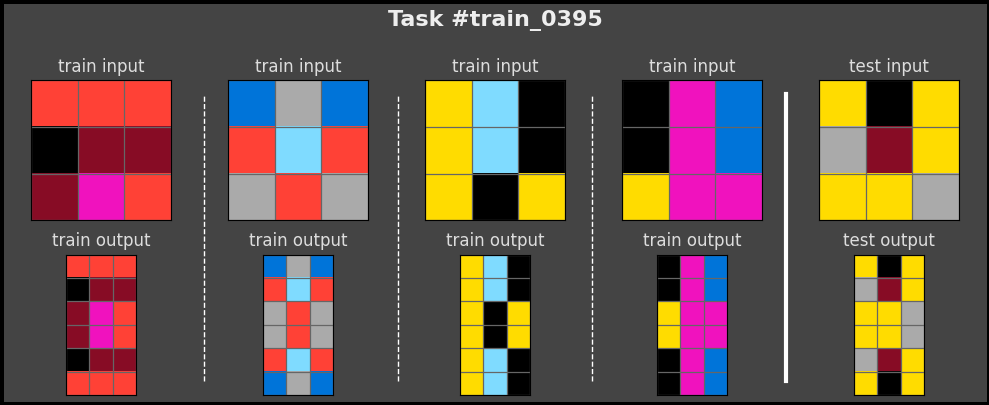

In [9]:
task_id, task = sample_arc_task(train_data, split=None)

test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

print(f"Sampled task: {task_id}")
visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9
)

In [10]:
%%time 

expected_shape = get_grid_shape(test_output)

out, _ = model.solve_with_llm(
    task=task, 
    expected_shape=expected_shape,
    verbose=True
)

[INFO] Expected shape: (6, 3)
[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com/ml-explore/mlx-lm/tree/main#large-models
[[4, 0, 4], [5, 9, 4], [4, 4, 5], [4, 4, 5], [5, 9, 4], [4, 0, 4]]
Prompt: 848 tokens, 112.509 tokens-per-sec
Generation: 55 tokens, 6.801 tokens-per-sec
Peak memory: 16.522 GB
CPU times: user 579 ms, sys: 3.26 s, total: 3.84 s
Wall time: 30.7 s


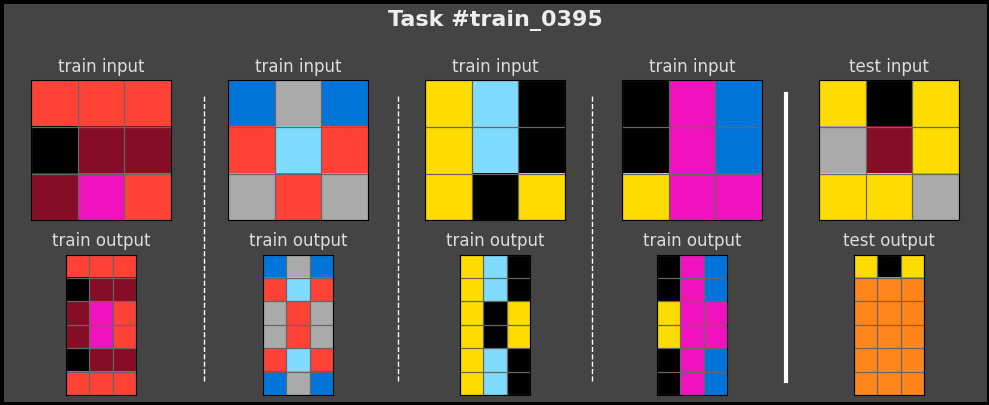

In [11]:
solution = {
    f"{task_id}": out
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Batch Solving

In [12]:
total_match = 0
total_pix_acc = 0
train_preds = []
N = 3

completion_times = []
expected_shape = None

for _ in range(N):
    task_id, task = sample_arc_task(train_data, split=None)    
    logger.info(f"{task_id=}")
    
    test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

    if test_output is not None:
        expected_shape = get_grid_shape(test_output)
    
    pred, completion_time = model.solve_with_llm(
        task=task, 
        expected_shape=expected_shape,
        verbose=True
    )  

    solution = {
        f"{task_id}": pred
    }
    
    train_preds.append(solution)
    completion_times.append(completion_time)

    metrics = model.evaluate(task, [pred])
    match, pix_acc = metrics.values()
        
    total_match+=match
    total_pix_acc+=pix_acc

    print()

avg_acc = total_match/N
avg_pix_acc = total_pix_acc/N
avg_completion_time = sum(completion_times)/N

print(f"{avg_acc*100:.5f}% correct matches with {avg_pix_acc*100:.5f}% pixel acc")

[INFO] task_id='train_0038'
[INFO] Expected shape: (10, 10)
[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com/ml-explore/mlx-lm/tree/main#large-models
[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 5, 7, 7, 7, 7, 7], [7, 7, 7, 5, 5, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 5, 5, 7], [7, 7, 7, 7, 7, 7, 7, 5, 7, 7], [7, 7, 5, 5, 7, 7, 7, 7, 7, 7], [7, 7, 7, 5, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 5, 5, 7, 7, 7], [7, 7, 7, 7, 5, 5, 7, 7, 7, 7]]
Prompt: 1984 tokens, 113.401 tokens-per-sec
Generation: 301 tokens, 6.275 tokens-per-sec
Peak memory: 17.170 GB

[INFO] task_id='train_0686'
[INFO] Expected shape: (18, 15)
[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com

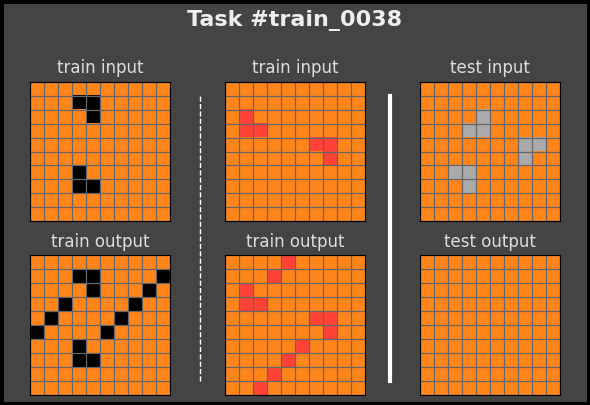

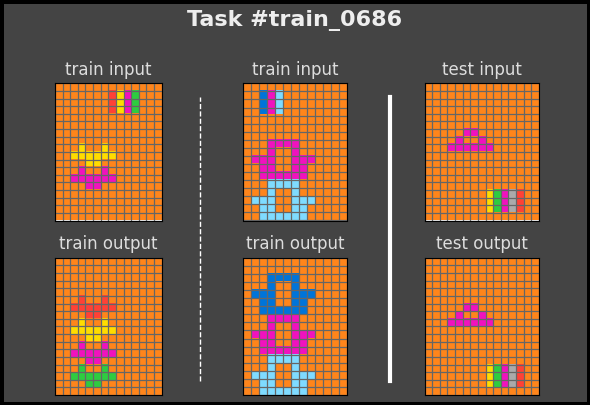

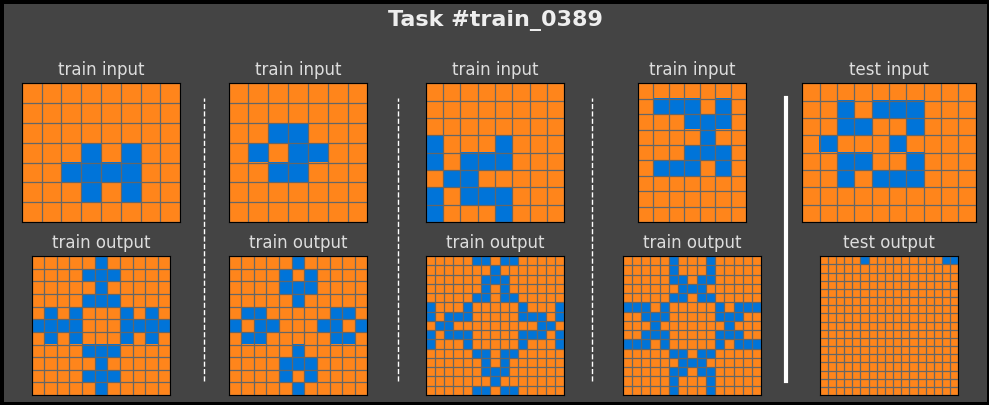

In [13]:
for solution in train_preds:
    task_id = list(solution.keys())[0]
    task = train_data[task_id]
    visualize_task(
        task_data=task,
        task_id=task_id, 
        size=2.0, 
        w1=.9,
        task_solutions=solution
    )

# Predict on Test Set

In [15]:
# Load sample submission to see the format
ss = pd.read_csv(
    osp.join("../", Config.data_path, 'SampleSubmission.csv'),
    dtype={"row": str}
)

print(f"✓ Sample submission has {len(ss)} predictions")

✓ Sample submission has 2303 predictions


In [16]:
test_out_rows = get_row_sizes(ss)
test_out_rows

,ID_,n_rows
0,test_0000,10
1,test_0001,12
2,test_0002,10
3,test_0003,8
4,test_0004,30
...,...,...
180,test_0180,25
181,test_0181,10
182,test_0182,19
183,test_0183,10


In [17]:
test_out_rows.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_rows,185.0,12.448649,7.509328,1.0,8.0,10.0,16.0,30.0


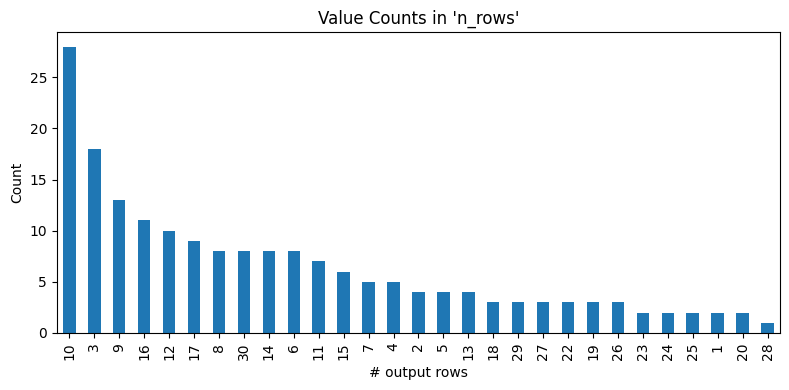

In [18]:
value_counts = test_out_rows["n_rows"].value_counts()

value_counts.plot(kind="bar", figsize=(8, 4))
plt.xlabel("# output rows")
plt.ylabel("Count")
plt.title("Value Counts in 'n_rows'")
plt.tight_layout()
plt.show()

In [19]:
task_id = "test_0004"
n_out_rows = test_out_rows.loc[test_out_rows["ID_"] == task_id, "n_rows"].item()
task = test_data[task_id]
train = task["train"]
test = task["test"][0]

inferred_out_shape = infer_out_shape(
    train_pairs=train, 
    test_input=test["input"],  
    expected_rows=n_out_rows,
    verbose=False
)

pred, completion_time = model.solve_with_llm(
    task=task, 
    expected_shape=inferred_out_shape,
    verbose=True
) 

[INFO] Expected shape: (30, 30)


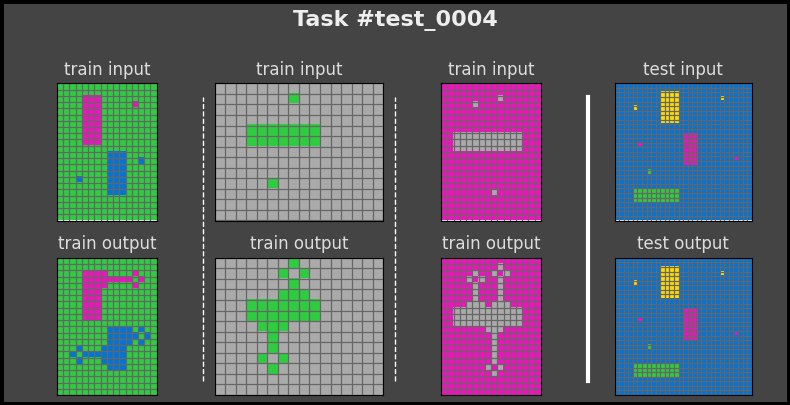

In [20]:
solution = {
    f"{task_id}": pred
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Submission

In [21]:
test_out_rows_sorted = test_out_rows.sort_values(by="n_rows", ascending=False)
test_out_rows_sorted

,ID_,n_rows
161,test_0161,30
36,test_0036,30
22,test_0022,30
74,test_0074,30
167,test_0167,30
...,...,...
143,test_0143,2
54,test_0054,2
108,test_0108,2
169,test_0169,1


In [ ]:
%%time

test_preds = []

for idx, row in tqdm(test_out_rows_sorted.iterrows(), total=len(test_out_rows_sorted)):
    
    task = test_data[row.ID_]
    train = task["train"]
    test = task["test"][0]

    inferred_out_shape = infer_out_shape(
        train_pairs=train, 
        test_input=test["input"],  
        expected_rows=row.n_rows,
        verbose=False
    )
    pred, completion_time = model.solve_with_llm(
        task=task, 
        expected_shape=inferred_out_shape,
        verbose=True
    )  

    test_preds.append(pred)


In [ ]:
def generate_submission(
    test_data,
    predictions, 
    expected_rows_list, 
    output_path="submission.csv"
):
    """
    Generates a CSV submission file by solving all test tasks.
    
    Args:
        test_data: dict of test_xxx: [{train: ..., test: ...}]
        predictions: list of predicted grids
        expected_rows_list: list of integers with expected number of rows (must align with keys order)
        output_path: output CSV file path
    """
    assert len(predictions) == len(expected_rows_list), "Mismatch between tasks and expected row counts"

    submission_rows = []
    test_keys = sorted(test_data.keys())

    for idx, task_id in enumerate(test_keys):
        task = test_data[task_id]  # Each task is wrapped in a list
        expected_rows = expected_rows_list[idx]

        pred = predictions[idx]
        for row_idx, row in enumerate(pred):
            row_str = "".join(str(cell) for cell in row)
            submission_rows.append((f"{task_id}_{row_idx+1}", row_str))

    # Write to CSV
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ID", "row"])
        writer.writerows(submission_rows)

    print(f"✅ Submission saved to {output_path}")

In [ ]:
date_str = datetime.now().strftime("%Y-%m-%d")
sub_filename = f"{date_str}-submission-{Config.model_name}-{Config.experiment}-{Config.target_platform}"

out_path = osp.join(Config.submission_path, sub_filename)

generate_submission(
    predictions=test_preds, 
    test_data=test_data, 
    expected_rows_list=test_out_rows.n_rows.values.tolist(), 
    output_path=out_path
)

In [ ]:
submision = pd.read_csv(out_path)
submision

In [ ]:
submision.shape == ss.shape, sum(submision.ID == ss.ID)/ss.shape[0]

In [ ]:
predictions = reconstruct_grids(submision)

In [ ]:
for i in range(30):
    task_id, task_data = sample_arc_task(test_data, split=None)    
    visualize_task(task_data=task_data,task_id=task_id, size=2.0, w1=.9, task_solutions=predictions)